In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
from lsst.ip.isr import IsrTask, IsrTaskConfig
from lsst.summit.utils.plotting import plot
import matplotlib.animation as animation
import imageio.v2 as imageio
import sys
sys.path.append('/home/s/seanmacb/Camera/DefectAnalysis/')
import run_six_utils as rsu

In [2]:
def fourPanelCrosshair(raw,processed,expLabels,expId,myKwargs,slicers=[[0,-1,0,-1],[0,-1,0,-1]],crosshair=[0,0]):
    '''
    Here, raw is a raw exposure
    processed is the processed exposure
    '''
    fig,axs = plt.subplots(2,2,figsize=[12,12])

    for exp,axesSet,expLabel,figureKwargs,mySlice,ylab in zip([raw,processed],axs,expLabels,myKwargs,slicers,["ADU","e-"]):
        imgResult = exp.getImage().array[mySlice[0]:mySlice[1],mySlice[2]:mySlice[3]]
        
        cax = axesSet[0].imshow(imgResult,**figureKwargs[0])
        axesSet[0].set_title("{} exposure\nexpId: {}\nOrigin located at ({},{})".format(expLabel,expId,mySlice[0],mySlice[2]))

        fig.colorbar(cax,cmap='PiYG')

        lowX,highX = axesSet[0].get_xlim()
        lowY,highY = axesSet[0].get_ylim()
        
        axesSet[0].axvline(crosshair[0],lowY,highY,color='red')
        axesSet[0].axhline(crosshair[1],lowX,highX,color='red')

        axesSet[0].set_xlabel("Serial Register")
        axesSet[0].set_ylabel("Parallel Register")
        
        crosshair1 = imgResult[crosshair[0]]
        crosshair2 = imgResult[crosshair[1]]

        axesSet[1].plot(crosshair1, label="Slice along x={}".format(crosshair[0]),**figureKwargs[1])
        axesSet[1].plot(crosshair2, label="Slice along y={}".format(crosshair[1]),**figureKwargs[1])
        axesSet[1].legend()
        axesSet[1].set_xlabel("Register position [pix]")
        axesSet[1].set_ylabel(ylab)
        axesSet[1].grid(ls='--')

        print("Median of trailing 5 pixels in {}: {}".format(expLabel,np.median([crosshair1[0:5],crosshair1[-5:],crosshair2[0:5],crosshair2[-5:]])))
        
    
    return fig,axs

In [3]:
run7Butler = Butler('embargo_new', collections=["LSSTComCam/raw/all","LSSTComCam/calib"])

## First, get a list of exposures

In [5]:
dayObs = 20241116
instrument = "LSSTComCam"
# runID = "E1498"

exposureList = []
for record in run7Butler.registry.queryDimensionRecords("exposure", 
                    where=f"exposure.day_obs={dayObs} and instrument='{instrument}'"):
                    # where=f"exposure.science_program in ('{runID}') and instrument='LSSTCam'"):
                                                    
    exposureList.append([record.id, record])
exposureList.sort(key=lambda x: x[0])
for [id,record] in exposureList:
    print(record.id, record.observation_type, record.exposure_time, record.physical_filter,record.exposure_time)


2024111600001 bias 0.0 z_03 0.0
2024111600002 bias 0.0 z_03 0.0
2024111600003 bias 0.0 z_03 0.0
2024111600004 bias 0.0 z_03 0.0
2024111600005 bias 0.0 z_03 0.0
2024111600006 bias 0.0 z_03 0.0
2024111600007 bias 0.0 z_03 0.0
2024111600008 bias 0.0 z_03 0.0
2024111600009 bias 0.0 z_03 0.0
2024111600010 bias 0.0 z_03 0.0
2024111600011 acq 1.0 r_03 1.0
2024111600012 acq 1.0 r_03 1.0
2024111600013 acq 1.0 r_03 1.0
2024111600014 acq 15.0 r_03 15.0
2024111600015 cwfs 30.0 r_03 30.0
2024111600016 cwfs 30.0 r_03 30.0
2024111600017 acq 30.0 r_03 30.0
2024111600018 cwfs 15.0 r_03 15.0
2024111600019 cwfs 15.0 r_03 15.0
2024111600020 acq 15.0 r_03 15.0
2024111600021 cwfs 15.0 r_03 15.0
2024111600022 cwfs 15.0 r_03 15.0
2024111600023 acq 15.0 r_03 15.0
2024111600024 cwfs 15.0 r_03 15.0
2024111600025 cwfs 15.0 r_03 15.0
2024111600026 acq 15.0 r_03 15.0
2024111600027 cwfs 15.0 r_03 15.0
2024111600028 cwfs 15.0 r_03 15.0
2024111600029 acq 15.0 r_03 15.0
2024111600030 cwfs 15.0 r_03 15.0
2024111600031 c

In [9]:
# expIdRange = np.arange(2024102000268,2024102000289)
dataDir = "/home/s/seanmacb/DATA/Run7Figures/VampireFigures" # where you will store the data

## Define a simple ISR
### Just overscan subtraction and bias subtraction.

In [7]:
isrConfig = IsrTaskConfig()
isrConfig.doLinearize=False
isrConfig.doOverscan=True
isrConfig.overscan.fitType="MEDIAN_PER_ROW"
isrConfig.overscan.doParallelOverscan=True
isrConfig.doAssembleCcd=True
isrConfig.doBias=False
isrConfig.doVariance=False
isrConfig.doCrosstalk=False
isrConfig.doBrighterFatter=False
isrConfig.doDark=False
isrConfig.doStrayLight=False
isrConfig.doFlat=False
isrConfig.doFringe=False
isrConfig.doApplyGains=True
isrConfig.usePtcGains=False
isrConfig.doDefect=False
isrConfig.doNanMasking=True
isrConfig.doInterpolate=False
isrConfig.doSaturation=False
isrConfig.doSaturationInterpolation=False
isrTask = IsrTask(config=isrConfig)

### Generate images for R22/S11/Segment13 (463, 1096)

In [93]:
reProcess=False

Median of trailing 5 pixels in Raw ComCam Acq: 3249.500244140625
Median of trailing 5 pixels in Processed ComCam Acq: 4565.1337890625


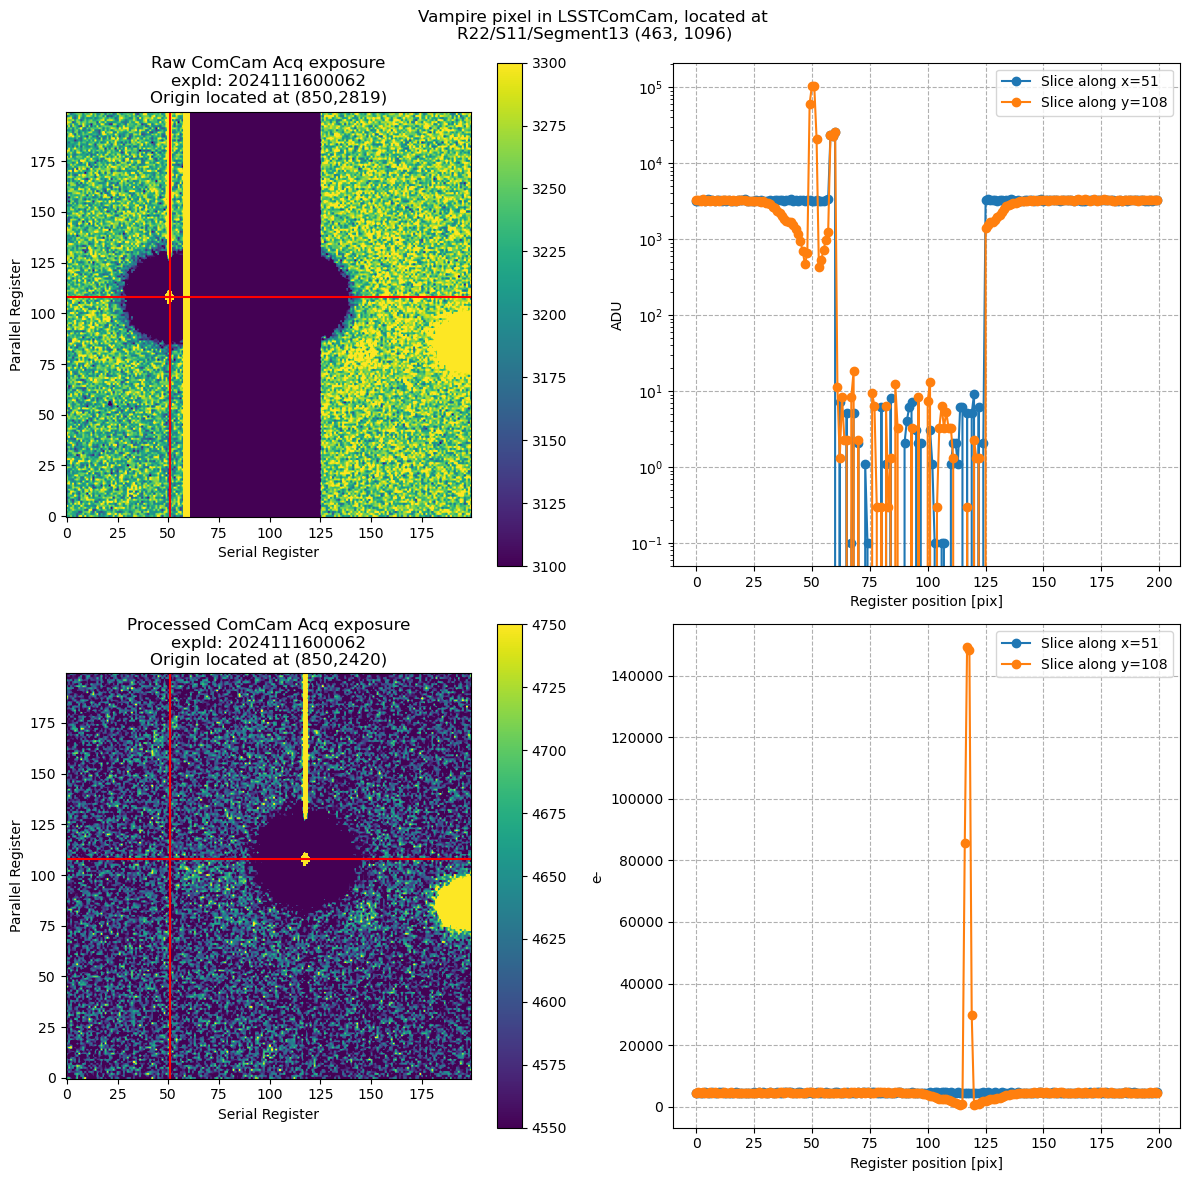

In [116]:
expId = 2024111600062

# if expId==expIdRange[0]:
#     myFigureKwargs = [[{"vmin":12000,"vmax":25000,"origin":'lower'},{'marker':'o'}],[{"vmin":20000,"vmax":50000,"origin":'lower'},{'marker':'o'}]]
# else:
#     myFigureKwargs = [[{"vmin":0,"vmax":60,"origin":'lower'},{'marker':'o'}],[{"vmin":0,"vmax":100,"origin":'lower'},{'marker':'o'}]]

myFigureKwargs = [[{"vmin":3100,"vmax":3300,"origin":'lower'},{'marker':'o'}],[{"vmin":4550,"vmax":4750,"origin":'lower'},{'marker':'o'}]]

slicers = [[850,1050,2420+67*6-3,2620+67*6-3],[850,1050,2420,2620]]
# slicers = [[0,-1,0,-1],[0,-1,0,-1]]

# crosshairs = [118,108]
crosshairs = [51,108]


if reProcess:
    detector = 4 # R21/S10
    instrument = 'LSSTComCam'
    exp = run7Butler.get('raw', detector=detector, exposure=expId, instrument=instrument)
    isrResult = isrTask.run(exp) # This runs the ISR

imgType = "ComCam Acq"
fig,axs = fourPanelCrosshair(exp,isrResult.exposure,["Raw {}".format(imgType),"Processed {}".format(imgType)], expId,myFigureKwargs,slicers,crosshairs)

fig.suptitle("Vampire pixel in LSSTComCam, located at \nR22/S11/Segment13 (463, 1096)")

# axs[1,1].semilogy()
axs[0,1].semilogy()


fig.tight_layout()
fig.savefig("/home/s/seanmacb/DATA/Run7Figures/VampireFigures/ComCam_{}_vampCrosshair_R22.S11.Segment13 (463, 1096)_onRaw.jpg".format(expId),dpi=180)

# figArr.append(fig)

### Generate images for R22/S01/Segment11 (95,750)

In [129]:
reProcess=False

Median of trailing 5 pixels in Raw ComCam Acq: 2168.6669921875
Median of trailing 5 pixels in Processed ComCam Acq: 5953.6435546875


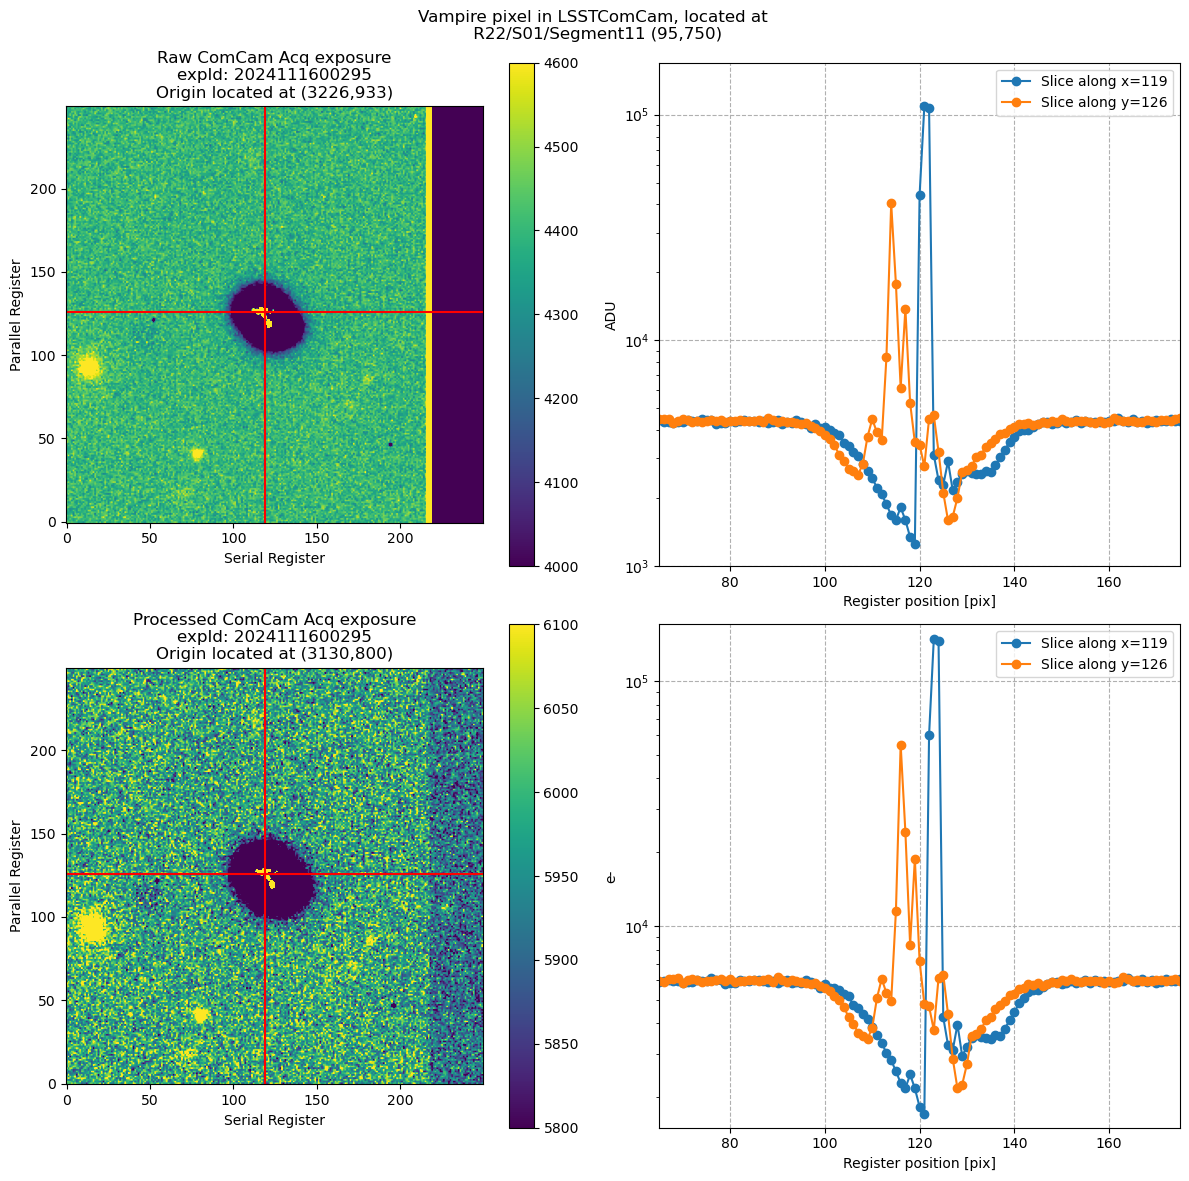

In [152]:
expId = 2024111600295

# if expId==expIdRange[0]:
#     myFigureKwargs = [[{"vmin":12000,"vmax":25000,"origin":'lower'},{'marker':'o'}],[{"vmin":20000,"vmax":50000,"origin":'lower'},{'marker':'o'}]]
# else:
#     myFigureKwargs = [[{"vmin":0,"vmax":60,"origin":'lower'},{'marker':'o'}],[{"vmin":0,"vmax":100,"origin":'lower'},{'marker':'o'}]]

myFigureKwargs = [[{"vmin":4000,"vmax":4600,"origin":'lower'},{'marker':'o'}],[{"vmin":5800,"vmax":6100,"origin":'lower'},{'marker':'o'}]]

slicers = [[3130+96,3380+96,800+67*2-1,1050+67*2-1],[3130,3380,800,1050]]
# slicers = [[0,-1,0,-1],[0,-1,0,-1]]

crosshairs = [119,126]

if reProcess:
    detector = 1 # R21/S10
    instrument = 'LSSTComCam'
    exp = run7Butler.get('raw', detector=detector, exposure=expId, instrument=instrument)
    isrResult = isrTask.run(exp) # This runs the ISR

imgType = "ComCam Acq"
fig,axs = fourPanelCrosshair(exp,isrResult.exposure,["Raw {}".format(imgType),"Processed {}".format(imgType)], expId,myFigureKwargs,slicers,crosshairs)
fig.suptitle("Vampire pixel in LSSTComCam, located at \n R22/S01/Segment11 (95,750)")

for ax in axs[:,1]:
    ax.semilogy()
    ax.set_xlim(65,175)

axs[0,1].set_ylim(1E3,1.7E5)
axs[1,1].set_ylim(1.5E3,1.7E5)

fig.tight_layout()
fig.savefig("/home/s/seanmacb/DATA/Run7Figures/VampireFigures/ComCam_{}__Detector{}_vampCrosshair.jpg".format(expId,detector),dpi=180)

# figArr.append(fig)

In [68]:
savedImageList = []
for expEntry in expIdRange:
    for dirEntry in os.listdir("{}/".format(dataDir)):
        if dirEntry.__contains__(str(expEntry)):
            savedImageList.append(dirEntry)